In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model_scratch import *

In [22]:
train_data=pd.read_csv('sign_mnist_train.csv')
test_data=pd.read_csv('sign_mnist_test.csv')

In [23]:
train_data['label'].unique() #index 0-24 (no 9 and 25)

array([ 3,  6,  2, 13, 16,  8, 22, 18, 10, 20, 17, 19, 21, 23, 24,  1, 12,
       11, 15,  4,  0,  5,  7, 14])

KeyError: 13

In [24]:
X_train=train_data.drop('label',axis=1).values
y_train=train_data['label'].values
X_test=test_data.drop('label',axis=1).values
y_test=test_data['label'].values

In [25]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((27455, 784), (27455,), (7172, 784), (7172,))

In [26]:
X_train_max=np.max(X_train, axis=1,keepdims=True)
X_train_min=np.min(X_train, axis=1,keepdims=True)
X_train1=(X_train-X_train_min)/(X_train_max-X_train_min)
X_test_max=np.max(X_test, axis=1,keepdims=True)
X_test_min=np.min(X_test, axis=1,keepdims=True)
X_test1=(X_test-X_test_min)/(X_test_max-X_test_min)

In [27]:
X_train1.shape,X_test1.shape

((27455, 784), (7172, 784))

In [28]:
X_train1[0][0],X_test1[0][0]

(np.float64(0.3939393939393939), np.float64(0.765625))

In [29]:
o_y_train=pd.get_dummies(y_train)
o_y_test=pd.get_dummies(y_test)

In [30]:
y_train1=o_y_train.astype('int')
y_test1=o_y_test.astype('int')

In [31]:
y_train1.shape,y_test1.shape

((27455, 24), (7172, 24))

In [32]:
X_train2=X_train1.reshape(-1,28,28,1)
X_test2=X_test1.reshape(-1,28,28,1)

In [33]:
class ConVLayers:
    def __init__(self,layers):
        self.layers=layers
        
    def forward(self,X):  # Fixed method signature
        cache=[self.layers[0].forward(X)]
        l=0
        for i in range(1,len(self.layers)):
            cache.append(self.layers[i].forward(cache[l][0]))
            l+=1
        return cache

    def backward(self,dZ,Y,cache):  # Fixed method signature
        for l in reversed(range(len(self.layers))):
            dZ = self.layers[l].backward(dZ, cache[l][1])
        return dZ

class Conv2D:
    def __init__(self,input_size,f,n_C,lr,stride=1):
        (m,H_prev,W_prev,n_C_prev)=input_size
        pad=(f-1)//2
        self.lr=lr
        (self.W,self.b)=initialize_conv_parameters(f,n_C_prev,n_C)
        self.params={'stride':stride,'pad':pad}

    def forward(self,A_prev):
        return conv_forward(A_prev,self.W,self.b,self.params)
        
    def backward(self,dZ,cache):
        dA_prev, dW, db = conv_backward(dZ,cache)
        # Update weights and biases
        self.W -= self.lr*dW
        self.b -= self.lr*db
        return dA_prev

class MaxPool2D:
    def __init__(self,f,stride):
        self.params={'f':f,'stride':stride}
    def forward(self,A_prev):
        return pool_forward(A_prev,self.params)
    def backward(self,dA,cache):
        return pool_backward(dA,cache)

class Dense:
    def __init__(self,layer_dims):
        self.params=initialize_parameters_deep(layer_dims)
    def forward(self,X):
        return L_model_forward(X,self.params)
    def backward(self,AL,Y,caches):
        return L_model_backward(AL,Y,caches)
    def update(self,grads,learning_rate):
        self.params= update_parameters(self.params,grads,learning_rate)
class CNN:
    def __init__(self,conv,dense):
        self.conv=conv
        self.dense=dense
    def forward(self,X):
        c=self.conv.forward(X)
        c1=c[-1][0].reshape(-1,X.shape[0])
        p=self.dense.forward(c1)
        return c,p
    def print_cost(self,p,Y):
        cost=compute_cost(p[0],Y)
        print(cost)
        return cost
    def backward(self,p,Y,c,lr):
        shape=c[-1][0].shape
        dZ=p[0].reshape(-1,p[0].shape[1])
        x=self.dense.backward(dZ,Y,p[1])
        dA=x['dA0']
        self.dense.update(x,lr)
        dA=dA.reshape(shape)
        self.conv.backward(dA,Y,c)


In [34]:
a = [
    Conv2D((5,28,28,1), 3, 128,0.001),     # 28x28 -> 28x28 (pad=1)
    MaxPool2D(2, 2),                  # 28x28 -> 14x14
    Conv2D((5,14,14,128), 3, 64,0.001),    # 14x14 -> 14x14 (pad=1)  
    MaxPool2D(2, 2),                  # 14x14 -> 7x7
    Conv2D((5,7,7,64), 3, 32,0.001),       # 7x7 -> 7x7 (pad=1)
    MaxPool2D(2, 2)                   # 7x7 -> 4x4
]

In [35]:
import json
# a = [
#     Conv2D((5,28,28,1), 3, 128,0.001),     # 28x28 -> 28x28 (pad=1)
#     MaxPool2D(2, 2),                  # 28x28 -> 14x14
#     Conv2D((5,14,14,128), 3, 64,0.001),    # 14x14 -> 14x14 (pad=1)  
#     MaxPool2D(2, 2),                  # 14x14 -> 7x7
#     Conv2D((5,7,7,64), 3, 32,0.001),       # 7x7 -> 7x7 (pad=1)
#     MaxPool2D(2, 2)                   # 7x7 -> 4x4
# ]
#                          activation shape    activation size     parameters    
# input                   (28,28,1)               784                 0
#conv1= (5x5), stride=1   (28, 28, 128)           100352              3328
#pool1= f=2, s=2          (14, 14, 128)           25088               0
#conv2= (3x3), stride=1   (14, 14, 64)            12544               640
#pool2= f=2, s=2          (7, 7, 64)              3136                0
#conv3= (3x3)  stride=1   (7, 7, 32)              1568                320
#pool3= f=2, s=2          (4, 4, 32)              512                 0
#dense1                   (512,1)                 512                 262145
#dense2= (softmax)        (10,1)                  10                  5121

conv=ConVLayers(a)
dens=Dense([512,24])
cnn=CNN(conv,dens)

def load_params_from_json(filename='final_params.json'):
    try:
        with open(filename, 'r') as f:
            params_dict = json.load(f)
        conv_params = [
            (np.array(params_dict['conv1']['W']), np.array(params_dict['conv1']['b'])),
            (np.array(params_dict['conv2']['W']), np.array(params_dict['conv2']['b'])),
            (np.array(params_dict['conv3']['W']), np.array(params_dict['conv3']['b']))
        ]
        dense_params = {k: np.array(v) for k, v in params_dict['dens'].items()}
        return conv_params, dense_params
    except (json.JSONDecodeError, FileNotFoundError):
        return None, None
# Update the model parameters
def save_params_to_json(params, filename='final_params.json'):
    params_dict = {
        'conv1': {'W': params[0][0].tolist(), 'b': params[0][1].tolist()},
        'conv2': {'W': params[1][0].tolist(), 'b': params[1][1].tolist()},
        'conv3': {'W': params[2][0].tolist(), 'b': params[2][1].tolist()},
        'dens': {k: v.tolist() for k, v in params[3].items()}
    }
    with open(filename, 'w') as f:
        json.dump(params_dict, f)
conv_params, dense_params = load_params_from_json()
for i, (W, b) in enumerate(conv_params):
    a[i*2].W = W
    a[i*2].b = b

dens.params = dense_params
idx=[i for i in range(10000)]
costs = []

def save_cost_to_file(cost, filename='costs.txt'):
    with open(filename, 'a') as f:
        f.write(f"{cost}\n")

# with open('costs.txt', 'r') as f:
#     start_index = len(f.readlines())

# for i in range(start_index, 100000):
#     params = [(a[0].W, a[0].b), (a[2].W, a[2].b), (a[4].W, a[4].b), dens.params]
#     save_params_to_json(params)
#     np.random.shuffle(idx)
#     y_train2 = y_train1[idx[0]:idx[0]+1].T.values
#     x_train3 = X_train2[idx[0]:idx[0]+1]
#     (c, p) = cnn.forward(x_train3)
#     cost = cnn.print_cost(p, y_train2)
#     cnn.backward(p, y_train2, c, 0.001)
#     costs.append(cost)
#     save_cost_to_file(cost)

In [40]:
import json
def save_params_to_json(params, filename='params.json'):
    params_dict = {
        'conv1': {'W': params[0][0].tolist(), 'b': params[0][1].tolist()},
        'conv2': {'W': params[1][0].tolist(), 'b': params[1][1].tolist()},
        'conv3': {'W': params[2][0].tolist(), 'b': params[2][1].tolist()},
        'dens': {k: v.tolist() for k, v in params[3].items()}
    }
    with open(filename, 'w') as f:
        json.dump(params_dict, f)

params = [(a[0].W, a[0].b), (a[2].W, a[2].b), (a[4].W, a[4].b), dens.params]
save_params_to_json(params)

In [77]:
conv_params, dense_params = load_params_from_json(filename='final_params.json')
if conv_params is not None and dense_params is not None:
    for j, (W, b) in enumerate(conv_params):
        a[j*2].W = W
        a[j*2].b = b
    dens.params = dense_params

In [47]:
def predict(X, parameters):
    """
    Predict class labels for input data.
    
    Arguments:
    X -- input data of shape (n_features, m_examples)
    parameters -- trained parameters from the L-layer model
    
    Returns:
    predictions -- vector of predictions of shape (1, m_examples)
    """
    # Forward propagation
    AL, _ = L_model_forward(X, parameters)
    
    # Get predictions by taking argmax of the output probabilities
    predictions = np.argmax(AL, axis=0)
    
    return predictions

def compute_accuracy(predictions, Y):
    """
    Calculate accuracy of predictions compared to true labels.
    
    Arguments:
    predictions -- vector of predictions of shape (1, m_examples)
    Y -- true labels vector of shape (n_classes, m_examples)
    
    Returns:
    accuracy -- scalar value, accuracy of predictions in percentage
    """
    # Convert one-hot encoded Y to class labels
    true_labels = np.argmax(Y, axis=0)
    
    # Calculate accuracy
    m = Y.shape[1]
    accuracy = np.sum(predictions == true_labels) / m * 100
    
    return accuracy



In [108]:
# (c, p) =cnn.forward(X_test2_norm[:1000])
# prediction=predict(c[-1][0].reshape(1000,-1),dens.params)
# ac=compute_accuracy(prediction,y_test1[:1000].T)
# print('ACR',ac)
# Read and preprocess the image
ima = cv.imread('D.jpg', cv.IMREAD_GRAYSCALE)
imga = cv.resize(ima, (28, 28)).reshape(28, 28, 1)

# Normalize the image using the same min-max scaling as X_train1
imga_max=np.max(imga)
imga_min=np.min(imga)
imga_norm=(imga-imga_min)/(imga_max-imga_min)

# Reshape the image to match the input shape of the CNN
imga_norm=imga_norm.reshape(-1, 28, 28, 1)

# Use the CNN model to predict the class of the image
(c, p) = cnn.forward(imga_norm)

# Get the prediction
prediction = predict(c[-1][0].reshape(1, -1), dens.params)

# Print the predicted class
print("Predicted class:", prediction[0])

Predicted class: 6


In [38]:
(c, p) =cnn.forward(X_test2[:1000])

In [39]:
prediction=predict(c[-1][0].reshape(1000,-1),dens.params)
ac=compute_accuracy(prediction,y_test1[:1000].T)
print('ACR',ac)

ACR 89.3


In [51]:
y_test1.T.shape

(24, 7172)

In [53]:
import cv2 as cv

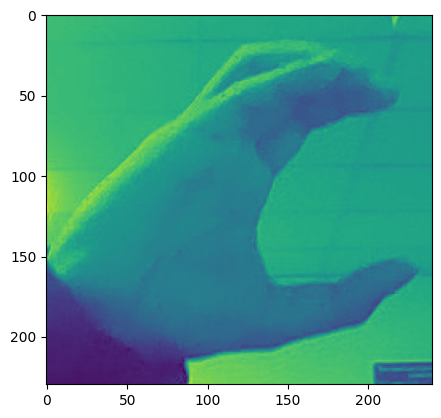

In [67]:
ima=cv.imread('C_hand1.jpg',cv.IMREAD_GRAYSCALE)
plt.imshow(ima)
plt.show()

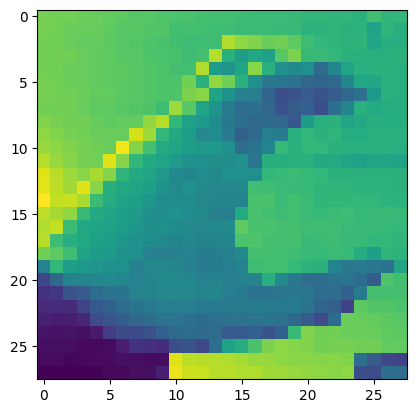

In [68]:
imga = cv.resize(ima, (28, 28)).reshape(28, 28, 1)
plt.imshow(imga.astype(np.uint8))

array([[207],
       [217],
       [240],
       ...,
       [218],
       [255],
       [231]])

In [58]:
X_train.shape

(27455, 784)

In [69]:
# Normalize the image using the same min-max scaling as X_train1
imga_max = np.max(imga)
imga_min = np.min(imga)
imga_norm = (imga - imga_min) / (imga_max - imga_min)

# Reshape the image to match the input shape of the CNN
imga_norm = imga_norm.reshape(-1, 28, 28, 1)

# Use the CNN model to predict the class of the image
(c, p) = cnn.forward(imga_norm)

# Get the prediction
prediction = predict(c[-1][0].reshape(1, -1), dens.params)

# Print the predicted class
print("Predicted class:", prediction[0])

Predicted class: 6


In [72]:
ac=compute_accuracy(prediction,y_test1[:1].T)
print('ACR',ac)

ACR 100.0
